In [1]:
from __future__ import division, print_function, unicode_literals, absolute_import
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Prepare the Data
In this notebook we load the data generated by the simulation and prepare it for the usage with brainstorm.
For this we:

  * load the data as np array from the csv file
  * split it into train and validation set
  * normalized the targets to be mean zero and standard deviation one
  * save the data to an HDF5 file

# Prepare Data

In [2]:
TRAIN_FRAC = 0.9

In [3]:
def normalize(data):
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    return (data - means) / stds, means, stds

In [5]:
X = np.genfromtxt('data.txt')
N, F = X.shape
F = 8
X.shape

(54567, 14)

In [6]:
input_data = X[:, 0:8].reshape(1, N, 8)
targets = X[:, 8:-1].mean(1).reshape(1, N, 1)
targets_std = X[:, 8:-1].std(1).reshape(1, N, 1)

# Normalize

* Rescale the inputs to be in the range [0, 1]
* Rescale the targets to have a std of 1

In [8]:
mins = np.round(input_data[0, :, :].min(0), decimals=2)
maxs = np.round(input_data[0, :, :].max(0), decimals=2)

input_data = (input_data - mins[None, None]) / (maxs - mins)[None, None]

tstd = targets.std()
targets /= tstd

### Visualize the data distribution
We visualize the distribution over all inputs to make sure its uniform and over the targets to get an impression of the typical values

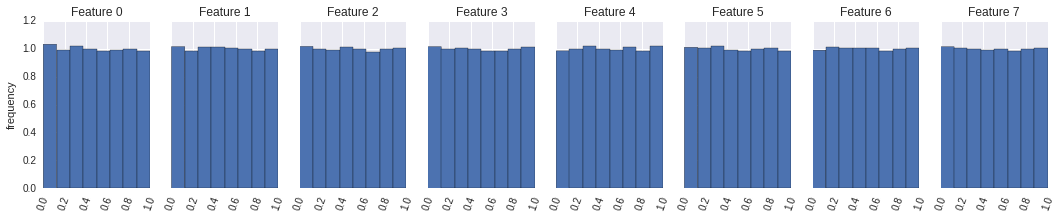

In [9]:
fig, axes = plt.subplots(ncols=F, figsize=(18, 3), sharey=True, sharex=True)
for i in range(F):
    axes[i].hist(input_data[0, :, i], normed=True, bins=8)
    axes[i].set_title("Feature {}".format(i))
    plt.setp( axes[i].xaxis.get_majorticklabels(), rotation=70 )
    #axes[i].set_xlabel('input value')
    
axes[0].set_ylabel('frequency')

In [10]:
fig.savefig('figures/inputs_distribution.pdf', bbox_inches='tight', pad_inches=0)

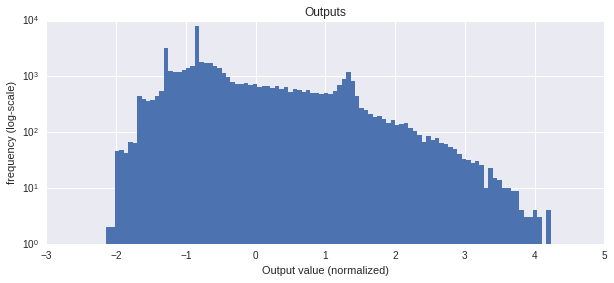

In [11]:
fig, ax = plt.subplots(figsize = (10, 4))
_ = ax.hist(targets[0, :, 0], bins=100, log=True, edgecolor='none')
_ = ax.set_title('Outputs')
ax.set_xlim((-3, 5))
ax.set_xlabel('Output value (normalized)')
ax.set_ylabel('frequency (log-scale)')

In [12]:
fig.savefig('figures/outputs_distribution.pdf', bbox_inches='tight', pad_inches=0)

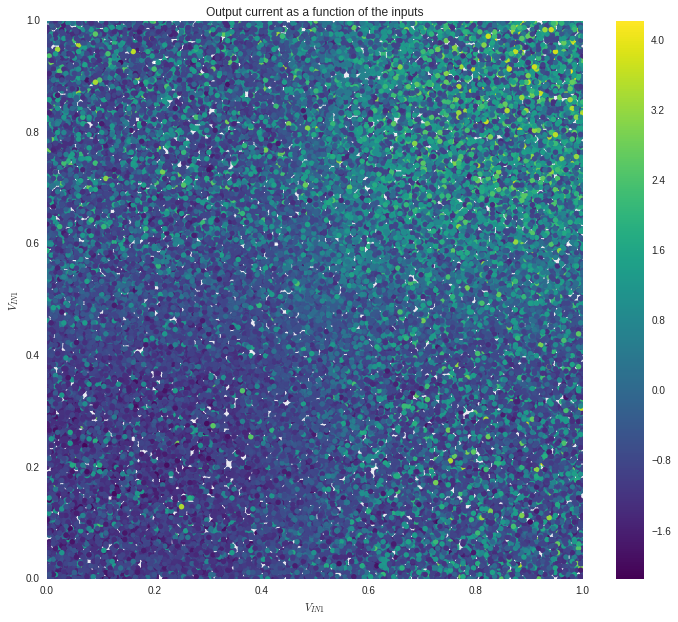

In [13]:
skip = None
idxs = np.arange(0, input_data.shape[1], skip)
np.random.shuffle(idxs)

fig, ax = plt.subplots(figsize=(12, 10))
tmp = ax.scatter(input_data[0, idxs, 0], input_data[0, idxs, 1],
           c=targets[0, idxs, 0], cmap='viridis', s=30, edgecolors='none')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xlabel('$V_{IN1}$')
plt.ylabel('$V_{IN1}$')
plt.title('Output current as a function of the inputs')
plt.colorbar(tmp)

# Split into Train and Validation

In [14]:
train_split = int(TRAIN_FRAC * input_data.shape[1])

train_data = input_data[:, :train_split, :]
val_data = input_data[:, train_split:, :]

train_targets = targets[:, :train_split, :]
val_targets = targets[:, train_split:, :]

# Write HDF5

In [15]:
with h5py.File('data50K.h5', 'w') as f:
    train = f.create_group('training')
    train.create_dataset('default', data=train_data, compression='gzip')
    f['training/default'].attrs['mins'] = mins
    f['training/default'].attrs['maxs'] = maxs
    #f['training/default'].attrs['means'] = means
    #f['training/default'].attrs['stds'] = stds
    f['training/targets'] = train_targets
    f['training/targets'].attrs['std'] = tstd

    val = f.create_group('validation')
    val.create_dataset('default', data=val_data, compression='gzip')
    f['validation/default'].attrs['mins'] = mins
    f['validation/default'].attrs['maxs'] = maxs
    #f['validation/default'].attrs['means'] = means
    #f['validation/default'].attrs['stds'] = stds
    f['validation/targets'] = val_targets
    f['validation/targets'].attrs['std'] = tstd
        